# Liquid Options DEX


### Покупка опциона у пула
1. Приходит человек и хочет купить ETH CALL K = 1200, N = 2.5. <br>
Чтобы посчитать стоимость опциона: <br>
а. цена дробится на тики, на каждом тике гипербола: $(N_{eth\:contracts\:to\:sell})*(N_{usd}$) = const. <br>
N - кол-во контрактов, которое можно продать. Короче мы $N_{eth}$ знаем + цену опциона на этом тике тоже знаем. То есть знаем х/у = $C_0$ (option price) и знаем y. Отсюда можем найти х и константу. Далее мы двигаемся по гиберполе до следующего тика (цена там $C_0$ + tick). Аналогично мы знаем изменение в кол-ве контрактов (2.5 -> 2.4) <br>

### Продажа опциона у пула
1. Можно просить частичных залог. И до тех пор пока залог продавца больше, чем ...., поддерживать. Потом -- ликвидировать.

2. В самом простом случае залог 100%

Провайдер ликвидности говорит: я даю тебе 1 eth, готов продавать (exp in 7d -> 21 Jan) коллы со страйком 1500 по цене от $ \$ 100$ до $ \$ 400.$ Один тик - один доллар. То есть на каждую цену от 100 до 400 будет по 0.033 eth ликвидности.

В случае покупок: Он дает $ \$1000 $ и говорит, что готов покупать коллы по цене от $ \$50 $ до $ \$95$. Это значит, что есть 45 долларов, на которые кладутся эти 1000 баксов. Это значит, что по цене $ \$52 $ он готов купить коллы на 1000/45 = $ \$22$. Эту сумму можно перевести в эфиры, это будет 22 / 1400 = 0.015 eth

<!-- 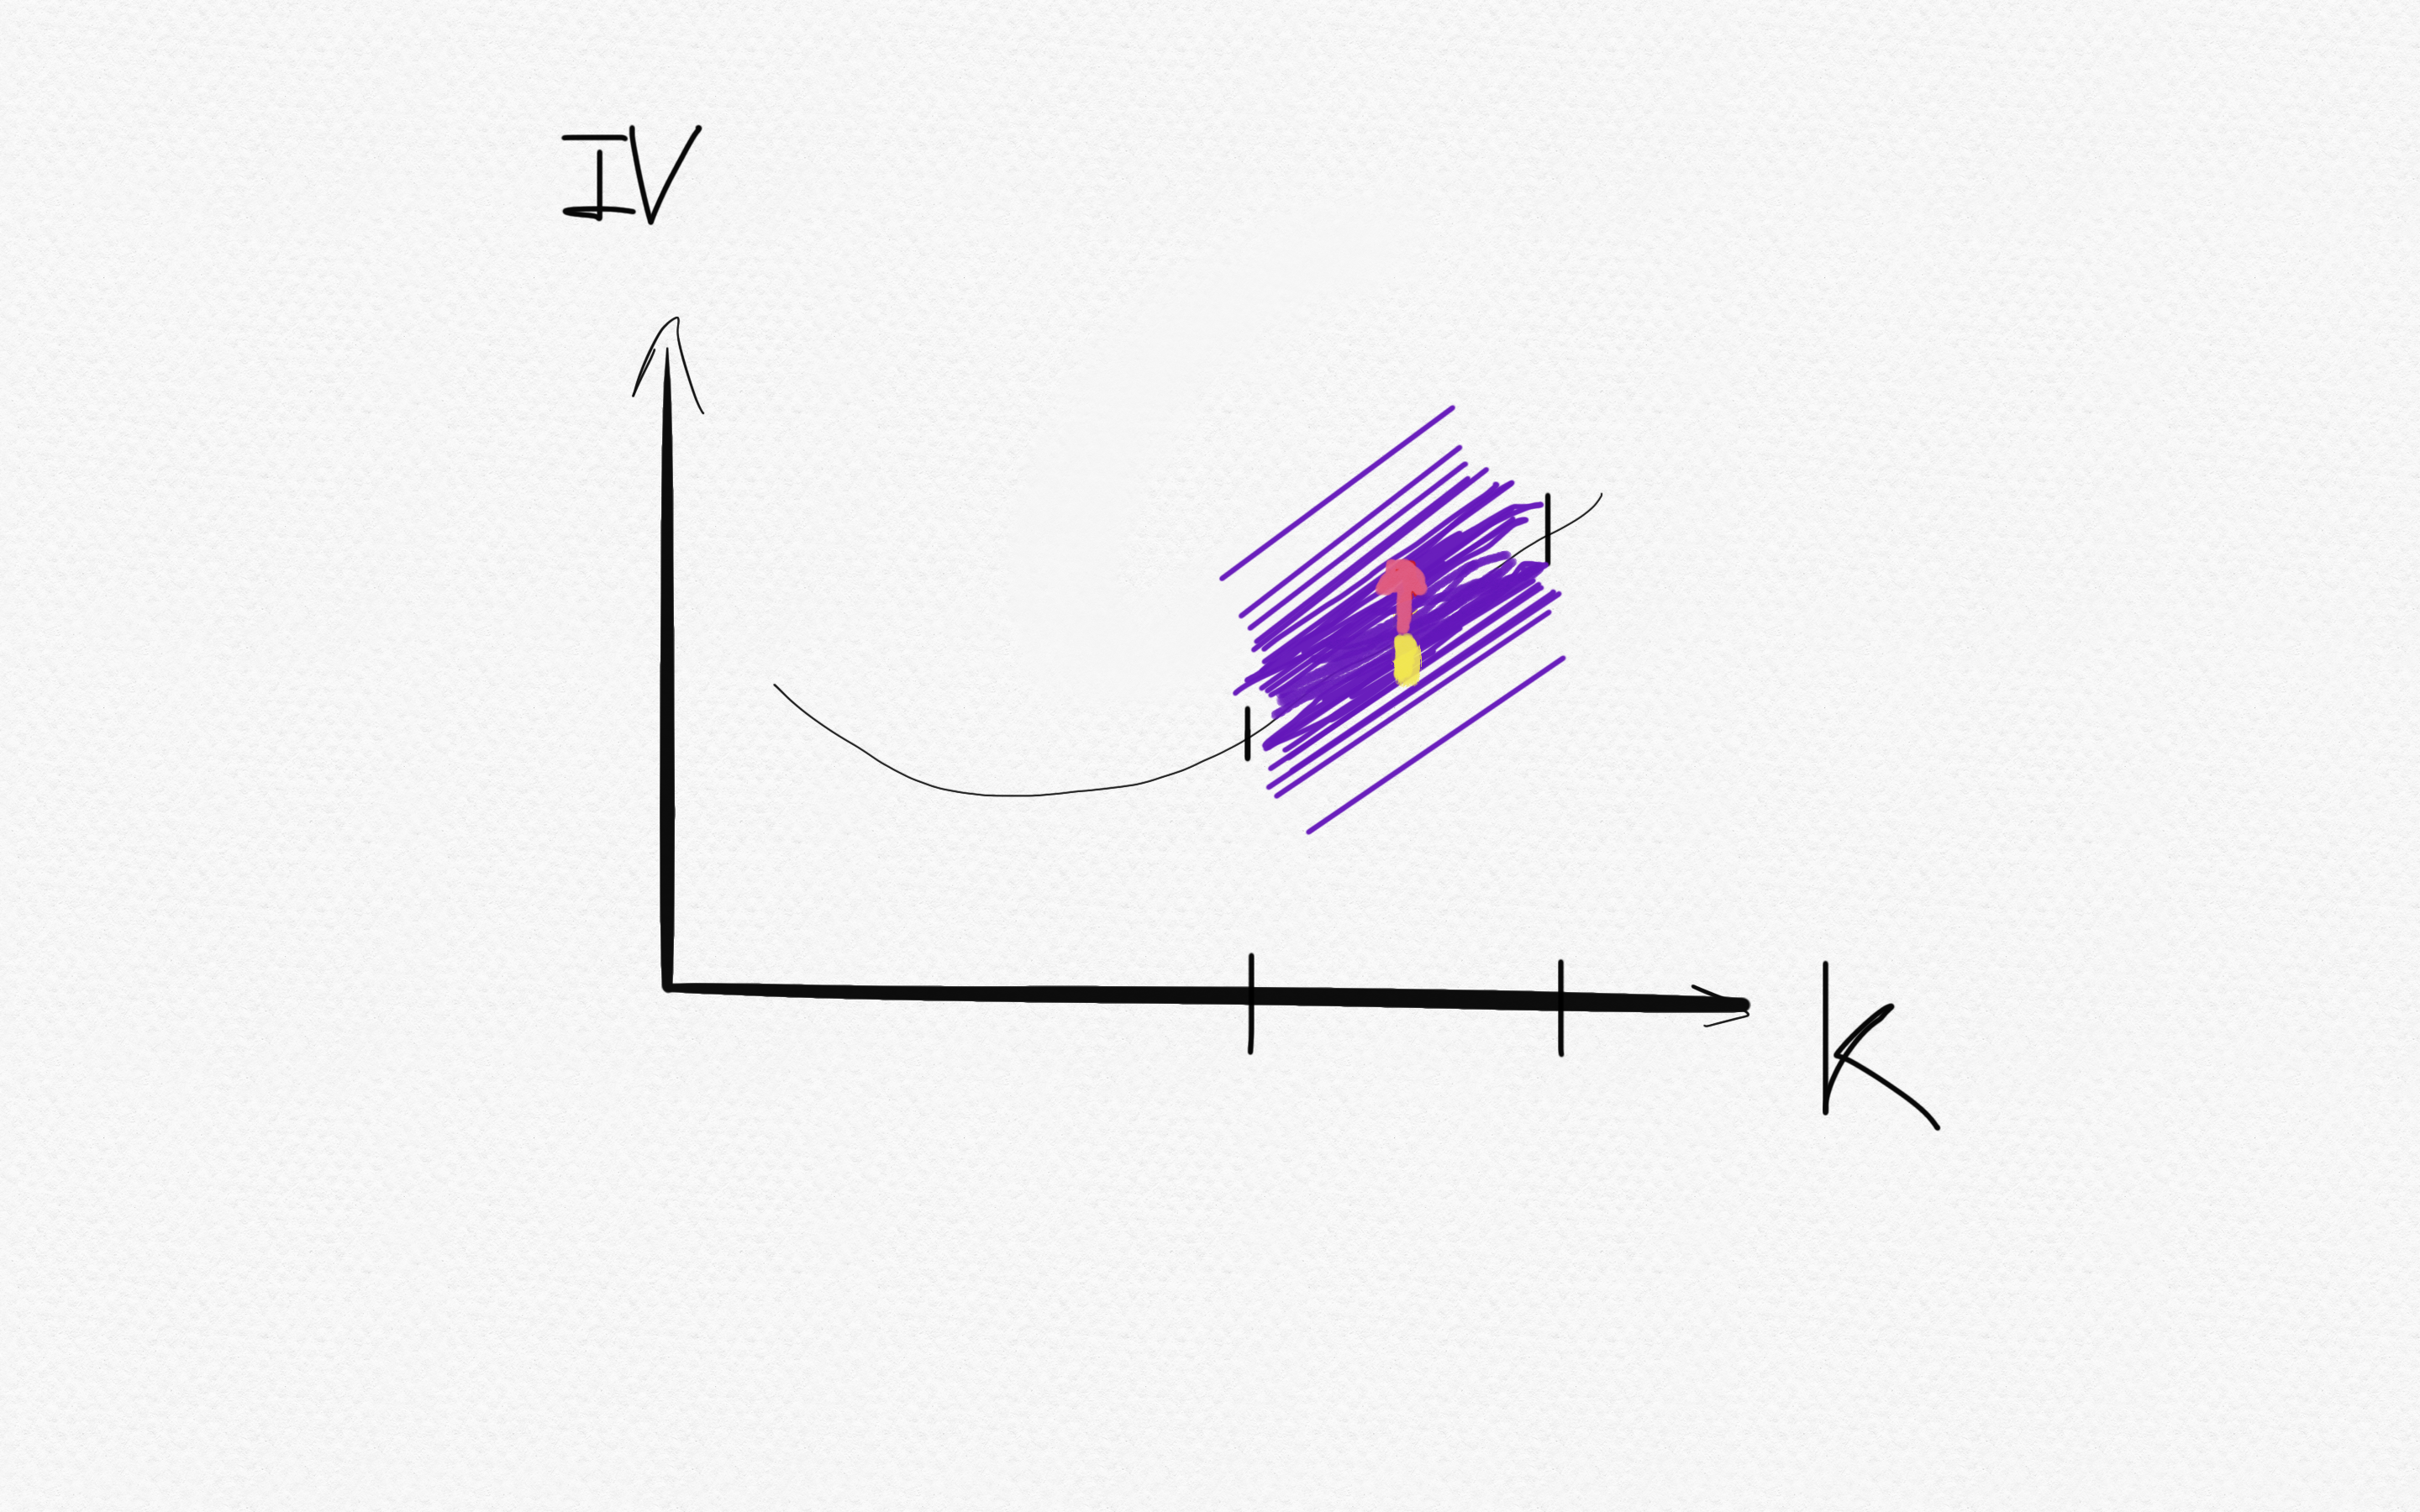 -->
<!-- 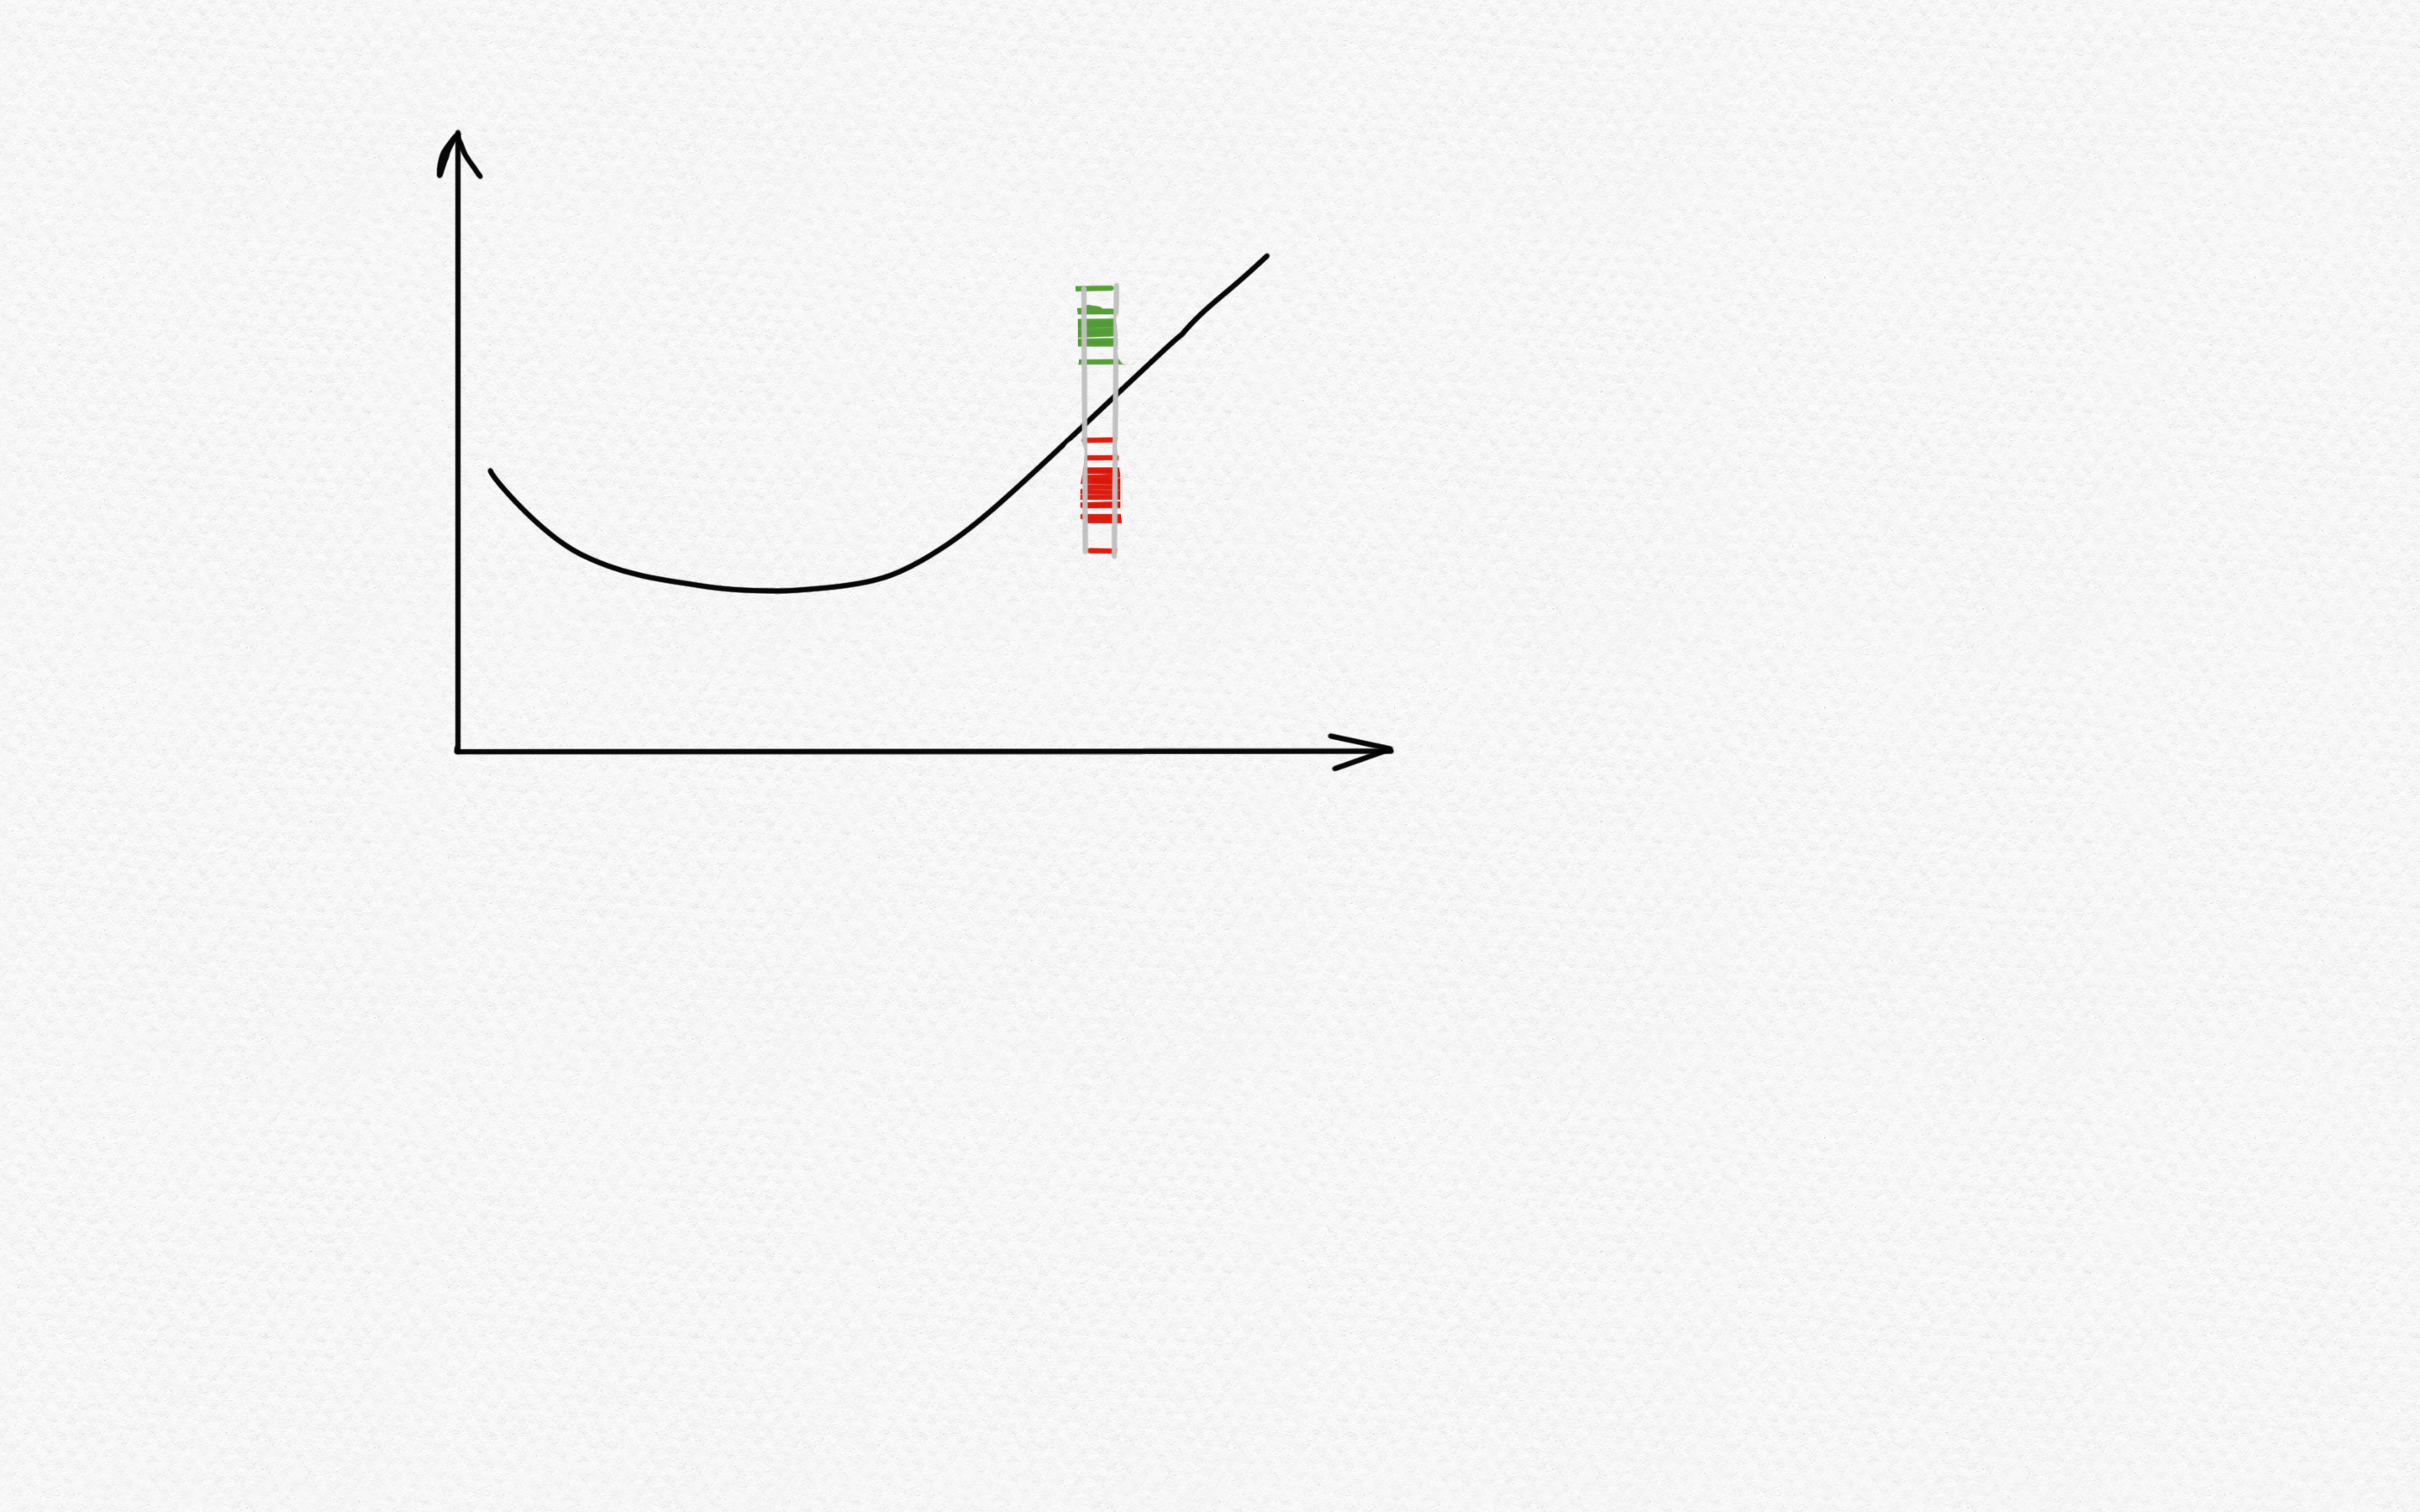 -->
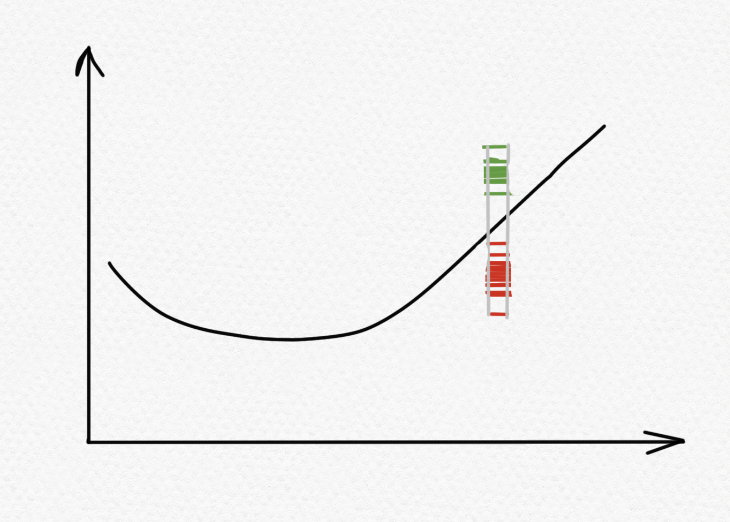

### Покупка у пула
Если юзер хочет купить у пула колл на 1 eth. Алгоритм идет по столбика ликвидности и блокирует 1 eth. При этом блокируется пропорционально долям в этом столбике. В сумме было в столбике 3 eth, значит станет доступно 2 eth. Премия делится тоже пропорционально.

### Продажа пулу

Если юзер хочет продать пулу колл на 1 eth, то он кладет залог (like 0.5-1 eth). 
Премия, которую он получит: алгоритм идет по столбикам и заполняет ордер. Получается средняя цена.

Если юзер дает не 100% от нужного залога, то есть цена ликвидации. 
1) Допустим он дает 100% залога. Тогда, тк это хранится на том же контракте, то у провайдеров ликвидности, если была заморозка актива, она снимается, пропорционально.
2) Минимальный размер коллатерала: если исполнить этот опцион сейчас, то профит должен быть меньше чем цена в долларах 

### Advantages

1. Перекрытая коллатеризация: если у пула сначала купили опцион, а потом продали ему опцион, то у провайдера ликвидности общая коллатеризация будет **разность**. А вот у человека, взаимодействующего с дексом, коллатеризация **суммируется**.
2. Не надо париться с выставлением бидов и асков. Просто выставляешь минимальную и максимальную цену, по которой готов покупать/продавать.
3. Ликвидность юзера размазывается на диапазон, соответственно он не продаст по минимальной цене всё что предоставил
4. Юзер в любой момент времени видит коллатеризацию своих активов, сделки (по какой цене сколько у него купили и продали). Например: куплено суммарно на $X$ по средней цене $C_1$, продано суммарно на $Y$ по средней цене $C_2$ + сколько коллатеризовано. 

### Hypothesis 1
User specifies minimum options price (for selling) and maximum option price (for buying)crunches


### Hypothesis 2
User specifies margin in % for buying and for selling

# Implementation

In [121]:
# libraries
import numpy as np
# from copy import deepcopy

In [961]:
class CallsContract:
    """Calls DEX contract"""
    
    def __init__(self, pair_name = 'ETH-USDC'):
        """IMPORTANT: I know that in 'for' below it's not optimal to put nested fors
        that do every time the same thing, but otherwise problem with linking appears"""
        self.pair_name = pair_name
        self.token0_balance = 0
        self.token0_freezed_balance = 0
        self.token1_balance = 0
        self.strikes_grid_spacing = 50
        self.strikes = [i for i in range(900, 2550, self.strikes_grid_spacing)]
        self.option_prices_grid_spacing = 1
        L = dict()

        for strike in self.strikes:
            bids_option_prices = dict()
            for option_price in range(0, max(self.strikes), self.option_prices_grid_spacing):
                bids_option_prices[option_price] = 0
        
            asks_option_prices = dict()
            for option_price in range(0, max(self.strikes), self.option_prices_grid_spacing):
                asks_option_prices[option_price] = 0
            
            L[strike] = {'bids': bids_option_prices, 'asks': asks_option_prices}
        self.liquidities = L
        self.whole_grid = dict()
        
    
    def LP_deposit_for_buying(self, strike, expiration_date, minimum_option_price, maximum_option_price,
            token0_amount):
        if strike not in self.strikes: 
            raise Exception('strike is not in available strikes')
        
        if minimum_option_price < 0 or maximum_option_price > max(self.strikes):
            raise Exception('invalid options prices range')
        
        if expiration_date not in self.whole_grid.keys():
            self.whole_grid[expiration_date] = self.liquidities
        
        density = token0_amount / ((maximum_option_price - minimum_option_price) / self.option_prices_grid_spacing)
        
        for option_price in range(minimum_option_price, maximum_option_price + 1, self.option_prices_grid_spacing):
            self.whole_grid[expiration_date][strike]['bids'][option_price] += density

        self.token1_balance += token0_amount
        
    def LP_deposit_for_selling(self, strike, expiration_date, minimum_option_price, maximum_option_price,
            token1_amount):
        """token1_amount is underlying asset, i.e eth"""
        
        if strike not in self.strikes: 
            raise Exception('strike is not in available strikes')
        
        if minimum_option_price < 0 or maximum_option_price > max(self.strikes):
            raise Exception('invalid options prices range')
        
        if expiration_date not in self.whole_grid.keys():
            self.whole_grid[expiration_date] = self.liquidities
        
        density = token1_amount / ((maximum_option_price - minimum_option_price) / self.option_prices_grid_spacing)
        
        for option_price in range(minimum_option_price, maximum_option_price + 1, self.option_prices_grid_spacing):
            self.whole_grid[expiration_date][strike]['asks'][option_price] += density
        self.token0_balance += token1_amount
        
    
    def LP_deposit(self, token0_amount, token1_amount, input1, input2):
        """If user wants to provide liquidity both for selling and buying options"""
        ## deposit for buying
        strike, expiration_date, minimum_option_price, maximum_option_price, token0_amount = input1
        LP_deposit_for_buying(strike, expiration_date, minimum_option_price, maximum_option_price, token0_amount)
        
        ## deposit for selling
        strike, expiration_date, minimum_option_price, maximum_option_price, token1_amount = input2
        LP_deposit_for_selling(strike, expiration_date, minimum_option_price, maximum_option_price, token1_amount)

    
    def buy_call(self, strike, expiration_date, amount):
        "if user wants to buy an option contract from options DEX"
        selected_grid = self.whole_grid[expiration_date][strike]['asks']
        filtered_selected_grid = {x:y for x,y in selected_grid.items() if y!=0}
        start_price = min(filtered_selected_grid, key=filtered_selected_grid.get)
        
        option_cost = 0
        price = start_price
        while amount > 0:
            # print(price, amount)
            x0 = filtered_selected_grid[price]
            pa = price
            pb = price + self.option_prices_grid_spacing
            L = x0 / (1 / np.sqrt(pa) - 1 / np.sqrt(pb))
            if (x0 >= amount):
                # print('x0 >= amount')
                y = L**2 / (x0 - amount + L / np.sqrt(pb)) - L * np.sqrt(pa)
                # print(f' беру {amount}, плачу {y}')
                option_cost += y
                self.whole_grid[expiration_date][strike]['asks'][price] = (x0 - amount)
                self.token0_freezed_balance += amount
                amount = 0
                break
            else:
                # print('x0 < amount')
                y = L * (np.sqrt(pb) - np.sqrt(pa))
                # print(f' беру {x0}, плачу {y}')
                option_cost += y
                amount -= x0
                self.whole_grid[expiration_date][strike]['asks'][price] = 0
                self.token0_freezed_balance += x0
                price += self.option_prices_grid_spacing
        
        self.token1_balance += option_cost
        return option_cost
    
    
    def sell_call(self, strike, expiration_date, amount):
        "if user wants to sell an option contract to options DEX"
        selected_grid = self.whole_grid[expiration_date][strike]['bids']
        filtered_selected_grid = {x:y for x,y in selected_grid.items() if y!=0}
        start_price = max(filtered_selected_grid.items(), key=lambda x: (x[0], x[1]))[0]
        print(start_price)
        option_cost = 0
        price = start_price
        while amount > 0:
            # print(price, amount)
            y0 = filtered_selected_grid[price]
            pa = price 
            pb = price + self.option_prices_grid_spacing
            L = y0 / (np.sqrt(pb) - np.sqrt(pa))
            x_max = L * (1 / np.sqrt(pa) - 1 / np.sqrt(pb))
            # print(y0, x_max)
            if (x_max >= amount):
                # print('x0 >= amount')
                y = L**2 / (x_max - amount + L / np.sqrt(pb)) - L * np.sqrt(pa)
                # print(f' беру {amount}, плачу {y}')
                option_cost += y
                self.whole_grid[expiration_date][strike]['bids'][price] = (x_max - amount)
                self.token0_balance += amount
                amount = 0
                break
            else:
                # print('x0 < amount')
                # y = L * (np.sqrt(pb) - np.sqrt(pa))
                # print(f' беру {x0}, плачу {y}')
                option_cost += y0
                amount -= x_max
                self.whole_grid[expiration_date][strike]['bids'][price] = 0
                self.token0_balance += x_max
                price -= self.option_prices_grid_spacing
        
        self.token1_balance -= option_cost
        return option_cost
            


    

#### Trade within one tick
Consider the purchase of option contract where amount is small (amount $< y_0$, $y_0$ is 'density' at tick $P_a$):


$$(x + \frac{L}{\sqrt{P_b}})(y + L\cdot \sqrt{P_a}) = L^2$$

When starting at new tick, $x_0$=0:

$$y_0 + L \cdot \sqrt{P_a} = L \cdot \sqrt{P_b} => L = \frac{y_0}{\sqrt{P_b} - \sqrt{P_a}}$$


$$(\Delta x + \frac{L}{\sqrt{P_b}})((y_0 - amount) + L \cdot \sqrt{P_a}) = L^2$$

Deriving $x_0$, we find the option price: 
$$C = \frac{\Delta x}{amount}$$


**P.S.** здесь ошибка, нужно было не х через у выражать, а наоборот. В коде это уже исправлено

In [962]:
Contract1 = CallsContract()

In [979]:
Contract1.LP_deposit_for_selling(900, '27Jan23', 500, 2000, 10)

Contract1.buy_call(900, '27Jan23', 1)

574.9997813631261

In [980]:
Contract1.LP_deposit_for_buying(900, '27Jan23', 700, 1000, 5000)

In [989]:
Contract1.sell_call(900, '27Jan23', 1)

895


889.6309404791411

In [982]:
# Contract1.liquidities[900]['bids']

In [983]:
Contract1.token0_freezed_balance

1.0